In [39]:
import os, json, re, math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from typing import Union, List, Dict, Any
import importlib
import utils
importlib.reload(utils)

<module 'utils' from '/Users/shanrulin/Desktop/ncg/LiveCodeBench/output/error_analysis/utils.py'>

In [40]:
zero = pd.DataFrame(load_records("/Users/shanrulin/Desktop/ncg/LiveCodeBench/output/Qwen2.5-Ins-7B-ZeroShotCoT/Scenario.selfrepair_1_0.2_eval_all.json"))
repair = pd.DataFrame(load_records("/Users/shanrulin/Desktop/ncg/LiveCodeBench/output/Qwen2.5-Ins-7B/Scenario.selfrepair_1_0.2_eval_all.json"))

df = pd.merge(zero, repair, on="question_title", suffixes=("_zero", "_repair"))


In [41]:
# === 1️⃣ 确保 error_message_zero / repair 存在 ===
for prefix in ["_zero", "_repair"]:
    meta_col = "metadata" + prefix
    err_col = "error_message" + prefix

    if err_col not in df.columns:
        if meta_col in df.columns:
            df[err_col] = df[meta_col].apply(extract_error_message)
        else:
            print(f"⚠️ Warning: {meta_col} not found, creating empty {err_col}")
            df[err_col] = ""

# === 2️⃣ ProblemType & ErrorType 分类 ===
for prefix in ["_zero", "_repair"]:
    title_col = "question_title"
    content_col = "question_content" + prefix

    # 有的版本里 content 不带后缀，这里保护一下
    if content_col not in df.columns and "question_content" in df.columns:
        content_col = "question_content"

    df["ProblemType" + prefix] = df.apply(
        lambda r: assign_problem_type({
            "question_title": r.get(title_col, ""),
            "question_content": r.get(content_col, "")
        }),
        axis=1
    )

    err_col = "error_message" + prefix
    if err_col in df.columns:
        df["ErrorType" + prefix] = df[err_col].apply(classify_error_better)
    else:
        print(f"⚠️ Warning: {err_col} not found, filling 'No Error Message'")
        df["ErrorType" + prefix] = "No Error Message"


In [42]:
print(df[["question_title", "ProblemType_zero", "ErrorType_zero", "ProblemType_repair", "ErrorType_repair"]].head())


   question_title     ProblemType_zero               ErrorType_zero  \
0   A. Short Sort  DataStructure-Queue  WrongAnswer-BooleanMismatch   
1     B. Good Kid  DataStructure-Queue  WrongAnswer-NumericMismatch   
2    D. 1D Eraser  DataStructure-Queue  WrongAnswer-NumericMismatch   
3    B. Chemistry  DataStructure-Queue             No Error Message   
4  C. Raspberries  DataStructure-Queue  WrongAnswer-NumericMismatch   

    ProblemType_repair             ErrorType_repair  
0  DataStructure-Queue  WrongAnswer-BooleanMismatch  
1  DataStructure-Queue                 RuntimeError  
2  DataStructure-Queue             No Error Message  
3  DataStructure-Queue             No Error Message  
4  DataStructure-Queue  WrongAnswer-NumericMismatch  


In [43]:
df["Success_zero"]  = df["pass@1_zero"] > 0
df["Success_repair"] = df["pass@1_repair"] > 0

df["Outcome"] = df.apply(
    lambda r: "Both Success" if r.Success_zero and r.Success_repair
    else "Only CoT" if (r.Success_zero and not r.Success_repair)
    else "Only Base" if (not r.Success_zero and r.Success_repair)
    else "Both Fail", axis=1)


In [87]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def compare_feature_diff(df, feature, top_n=7, save_dir="results", mode="count",
                         legend_y_offset=-0.22, figsize=(11,6), dpi=300,
                         bar_height=0.2):
    """
    PPT 优化版：条更细，宽度短一点，整体紧凑。
    Legend 在左下角竖排，不遮挡 X 轴。
    """
    os.makedirs(save_dir, exist_ok=True)

    # === 数据聚合 ===
    counts = (
        df.groupby(["Outcome", feature])
          .size()
          .reset_index(name="count")
          .pivot(index=feature, columns="Outcome", values="count")
          .fillna(0)
    )
    for col in ["Zero Only", "Repair Only", "Both Fail", "Both Pass"]:
        if col not in counts.columns:
            counts[col] = 0

    counts["Total"] = counts.sum(axis=1)
    if mode == "pct":
        counts["ZeroVal"] = counts["Zero Only"] / counts["Total"] * 100
        counts["RepairVal"] = counts["Repair Only"] / counts["Total"] * 100
        counts["NetGainVal"] = counts["RepairVal"] - counts["ZeroVal"]
        xlabel = "Percentage of Total Cases (%)"
        suffix = "_pct"
    else:
        counts["ZeroVal"] = counts["Zero Only"]
        counts["RepairVal"] = counts["Repair Only"]
        counts["NetGainVal"] = counts["RepairVal"] - counts["ZeroVal"]
        xlabel = "Number of Cases"
        suffix = "_count"

    top = counts.sort_values("NetGainVal", ascending=False)
    top = top[top["Total"] > 0].head(top_n)
    if top.empty:
        print("⚠️ No non-zero rows to plot for", feature)
        return pd.DataFrame()

    # === 绘图 ===
    fig, ax = plt.subplots(figsize=figsize)
    max_val = max(top["ZeroVal"].max(), top["RepairVal"].max()) * 1.05
    if max_val == 0:
        max_val = 1.0

    # 灰色背景参考带
    ax.barh(top.index, [-max_val] * len(top), height=bar_height, color="#f7f7f7", alpha=1.0)
    ax.barh(top.index, [max_val] * len(top), height=bar_height, color="#f7f7f7", alpha=1.0)

    # 主体条形图
    sns.barplot(y=top.index, x=-top["ZeroVal"], color="#e8a899",
                label="Zero Only (Pass)", ax=ax, height=bar_height)
    sns.barplot(y=top.index, x=top["RepairVal"], color="#8fb3d9",
                label="Repair Only (Pass)", ax=ax, height=bar_height)

    ax.axvline(0, color="black", lw=1.0)
    ax.grid(axis="x", linestyle="--", alpha=0.35)

    # === 样式 ===
    ax.set_title(f"Repair vs Zero Comparison by {feature.replace('_zero','').title()} (Top {top_n})",
                 fontsize=22, weight="bold", pad=14)
    ax.set_xlabel(xlabel, fontsize=16, labelpad=8)
    ax.set_ylabel(feature.replace('_zero','').title(), fontsize=16, labelpad=8)
    ax.tick_params(axis="both", which="major", labelsize=14)

    # === 标注 ===
    for i, row in enumerate(top.itertuples()):
        ax.text(0, i - 0.2, f"Total={int(row.Total)}",
                ha="center", va="center", fontsize=12, color="#333333")
        off = max(abs(row.RepairVal), abs(row.ZeroVal)) * 0.15 + max_val * 0.03
        ax.text(off if row.NetGainVal >= 0 else -off, i,
                f"Δ={row.NetGainVal:+.0f}{'%' if mode=='pct' else ''}",
                va="center", ha="left" if row.NetGainVal >= 0 else "right",
                fontsize=13, weight="bold", color="#111")

    # === Legend 左下角竖排 ===
    plt.subplots_adjust(bottom=0.20)
    legend = ax.legend(loc="lower left",
                       bbox_to_anchor=(0.02, legend_y_offset),
                       frameon=False,
                       fontsize=14,
                       ncol=1,
                       handlelength=1.6,
                       handletextpad=0.6)
    legend.set_zorder(20)

    plt.tight_layout(rect=[0, 0.02, 1, 0.98])
    fname = f"{feature.replace('_zero','')}_repair_vs_zero_top{top_n}{suffix}_ppt.png"
    save_path = os.path.join(save_dir, fname)
    plt.savefig(save_path, dpi=dpi, bbox_inches="tight")
    plt.show()
    print(f"✅ Saved: {save_path}")

    display_df = top[["Zero Only", "Repair Only", "Total", "ZeroVal", "RepairVal", "NetGainVal"]]
    print(f"\n==== Top {top_n} {feature.replace('_zero','').title()} by Repair–Zero Difference ====")
    print(display_df.to_string())

    return display_df


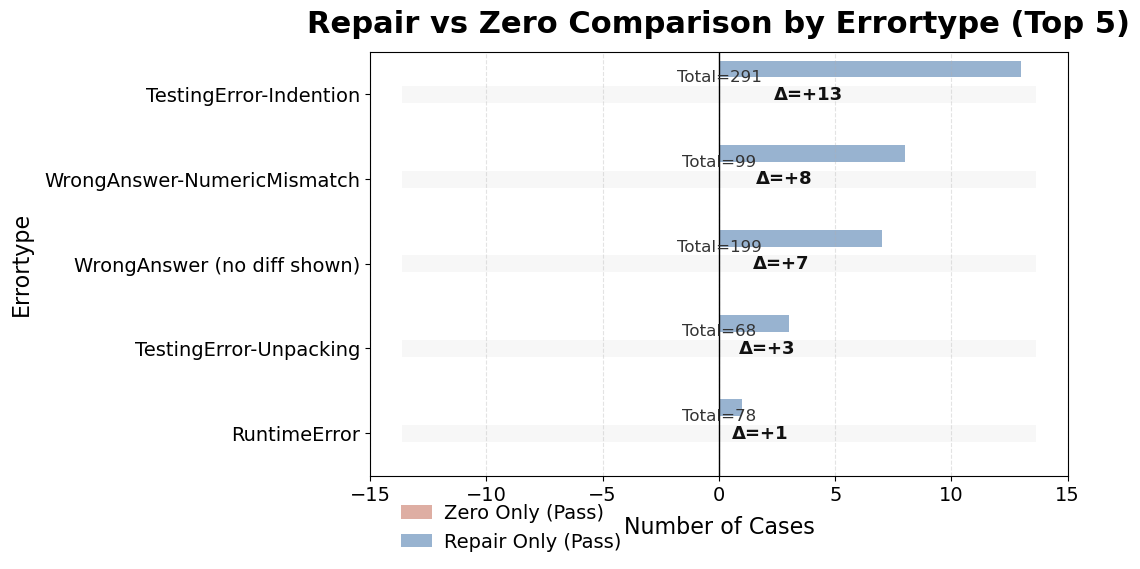

✅ Saved: results/ErrorType_repair_vs_zero_top5_count_ppt.png

==== Top 5 Errortype by Repair–Zero Difference ====
Outcome                      Zero Only  Repair Only  Total  ZeroVal  RepairVal  NetGainVal
ErrorType_zero                                                                            
TestingError-Indention             0.0         13.0  291.0      0.0       13.0        13.0
WrongAnswer-NumericMismatch        0.0          8.0   99.0      0.0        8.0         8.0
WrongAnswer (no diff shown)        0.0          7.0  199.0      0.0        7.0         7.0
TestingError-Unpacking             0.0          3.0   68.0      0.0        3.0         3.0
RuntimeError                       0.0          1.0   78.0      0.0        1.0         1.0


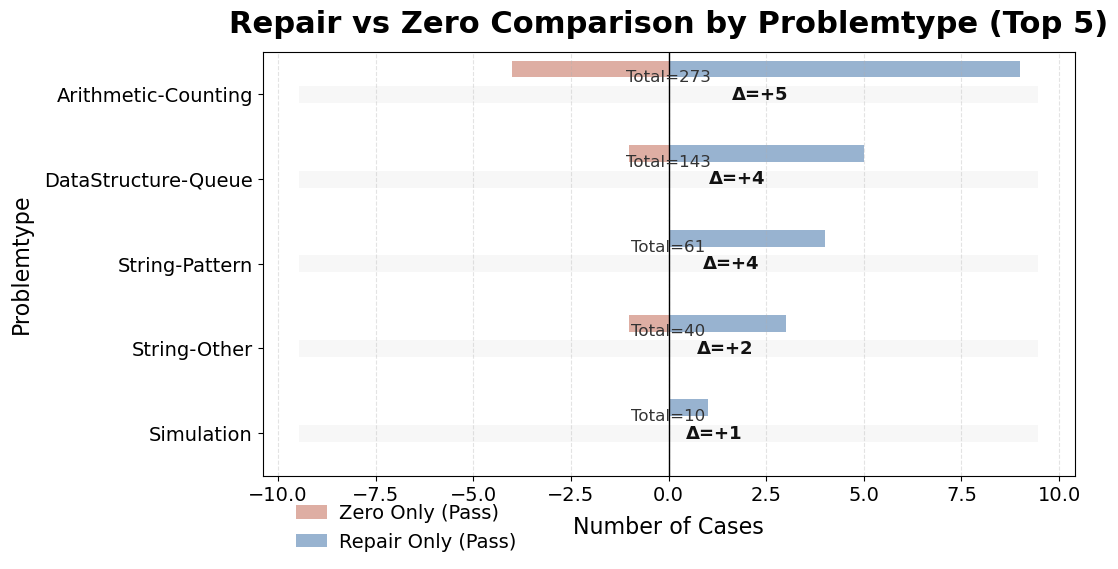

✅ Saved: results/ProblemType_repair_vs_zero_top5_count_ppt.png

==== Top 5 Problemtype by Repair–Zero Difference ====
Outcome              Zero Only  Repair Only  Total  ZeroVal  RepairVal  NetGainVal
ProblemType_zero                                                                  
Arithmetic-Counting        4.0          9.0  273.0      4.0        9.0         5.0
DataStructure-Queue        1.0          5.0  143.0      1.0        5.0         4.0
String-Pattern             0.0          4.0   61.0      0.0        4.0         4.0
String-Other               1.0          3.0   40.0      1.0        3.0         2.0
Simulation                 0.0          1.0   10.0      0.0        1.0         1.0


Outcome,Zero Only,Repair Only,Total,ZeroVal,RepairVal,NetGainVal
ProblemType_zero,,,,,,
Arithmetic-Counting,4.0,9.0,273.0,4.0,9.0,5.0
DataStructure-Queue,1.0,5.0,143.0,1.0,5.0,4.0
String-Pattern,0.0,4.0,61.0,0.0,4.0,4.0
String-Other,1.0,3.0,40.0,1.0,3.0,2.0
Simulation,0.0,1.0,10.0,0.0,1.0,1.0


In [88]:
compare_feature_diff(df, "ErrorType_zero", top_n=5, mode="count")
compare_feature_diff(df, "ProblemType_zero", top_n=5, mode="count")


In [53]:
print(df.columns.tolist()[:20])  # 看看有没有 Outcome, ErrorType_zero
print(df["Outcome"].value_counts(dropna=False))
print(df["ErrorType_zero"].value_counts(dropna=False).head())
print(df["ErrorType_repair"].value_counts(dropna=False).head())


['question_title', 'question_content_zero', 'platform_zero', 'question_id_zero', 'contest_id_zero', 'contest_date_zero', 'starter_code_zero', 'difficulty_zero', 'output_list_zero', 'code_list_zero', 'graded_list_zero', 'pass@1_zero', 'metadata_zero', 'original_code_list_zero', 'question_content_repair', 'platform_repair', 'question_id_repair', 'contest_id_repair', 'contest_date_repair', 'starter_code_repair']
Outcome
Both Fail      749
Both Pass      262
Repair Only     34
Zero Only       22
Name: count, dtype: int64
ErrorType_zero
TestingError-Indention         291
No Error Message               284
WrongAnswer (no diff shown)    199
WrongAnswer-NumericMismatch     99
RuntimeError                    78
Name: count, dtype: int64
ErrorType_repair
No Error Message               296
WrongAnswer-NumericMismatch    216
WrongAnswer (no diff shown)    177
TestingError-Indention          97
TestingError-Unpacking          96
Name: count, dtype: int64


In [55]:
print(df.groupby("Outcome")["ErrorType_zero"].value_counts().head(20))


Outcome      ErrorType_zero             
Both Fail    TestingError-Indention         278
             WrongAnswer (no diff shown)    192
             WrongAnswer-NumericMismatch     91
             RuntimeError                    77
             TestingError-Unpacking          65
             Timeout                         19
             WrongAnswer-BooleanMismatch     19
             WrongAnswer-SymbolMismatch       6
             TestingError-Other               2
Both Pass    No Error Message               262
Repair Only  TestingError-Indention          13
             WrongAnswer-NumericMismatch      8
             WrongAnswer (no diff shown)      7
             TestingError-Unpacking           3
             RuntimeError                     1
             Timeout                          1
             WrongAnswer-BooleanMismatch      1
Zero Only    No Error Message                22
Name: count, dtype: int64


In [66]:
print(df["Outcome"].value_counts())


Outcome
Both Fail      749
Both Pass      262
Repair Only     34
Zero Only       22
Name: count, dtype: int64
